
## Outlier Detection in Multivariate Datasets

#### Evan Sivil
#### Jackson School of Geosciences, UT Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The University of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)

### Executive Summary

As data scientists attempt to create reliable models in ever increasing datasets, the curse of dimensionality causes many issues to arise. One such issue is the presence of anomalous datapoints and the need to detect these occurrences as data is being collected. Isolation Forest (iForest) has been applied to detect anomalies in natural systems such as a credit card fraud in data security or malignancy in health care results. For this investigation it was found that Isolation Forest, makes a capable method for classifying anomalous data from outliers, but more work would need to be done in the presence of natural geologic events.

### Import Packages

In [44]:
import pandas as pd #pandas for datamanagement
import numpy as np #numpy for array management
from numpy.random import default_rng #random number generator for isotree emulation
import matplotlib.pyplot as plt #plotting
from sklearn.ensemble import IsolationForest #isoforest
from sklearn.metrics import classification_report, accuracy_score, make_scorer,f1_score,confusion_matrix #scoring metrics
from sklearn.model_selection import train_test_split,GridSearchCV #for model tuning and splitting
import seaborn as sns #plotting confusionmetrix
import math #for log calculation

### Functions

The following functions will be used in the workflow. This first function sets up the graph's shape and scatter plot. 

In [3]:
def plot_create(df, ax1=0, ax2=1, figuresize=(18,6)):                               #creates plot for visualization
    plt.figure(figsize=figuresize); plt.grid();
    plt.xlabel(df.columns[ax1]);plt.ylabel(df.columns[ax2]); plt.title('Isolation Forest '+df.columns[ax1]+' vs. '+df.columns[ax2]);
    plt.scatter(df.iloc[:,ax1], df.iloc[:,ax2], facecolors='none', edgecolors='b') 

Plots vertical/horizontal line on the graph using the results from the Isolation Tree.

In [4]:
def plot_split(axis, split, arr, color='r', linewidth=1.0): #plot the splits in red
    if axis==0: plt.vlines(x=split, ymin=arr[0][axis-1][0], ymax=arr[0][axis-1][1], lw=1, color=color, linestyle='-', linewidth=linewidth)
    else: plt.hlines(y=split, xmin=arr[0][axis-1][0], xmax=arr[0][axis-1][1],lw=1, color=color, linestyle='-', linewidth=linewidth)

This function is designed to reconstruct the Isolation Tree for user specified datapoints.

In [5]:
def reconstruct(data, *ax1, linewidth): #args allows for multiple index points to be reconstructed
    plot_create(data, 0, 1, figuresize=(18,3));colors=['g','k','y','c','m','k'] #create plot
    for z, color in zip(ax1, colors):
        plt.scatter(data.iloc[z][0], data.iloc[z][1], facecolors=color, edgecolors=color, label= (data.iloc[z][data.columns[0]],data.iloc[z][data.columns[1]])); plt.legend()
        print('Index', z,': (', data.iloc[z][data.columns[0]], ',', data.iloc[z][data.columns[1]], '): required ', data.iloc[z]['NodeLength'], ' trees to isolate')
        for x in data.iloc[z]['Reconstruct']: #passes array points to plot fxn
            plot_split(x[0][0], x[0][1], [[[x[1][0][0],x[1][0][1]],[x[1][1][0], x[1][1][1]]]], color=color, linewidth=linewidth)

This function splits the data and returns a train and test set.

In [6]:
def datasplit(df, splitsize, features, target): #split the data
    features = [feature for feature in features if feature not in [target]] #all columns submitted that is not the target is a feature
    x = df[features]; y = df[target]
    x_train, x_test, y_train, y_test = train_test_split(x.values, y.values,test_size=splitsize, random_state=42)
    return x_train, x_test, y_train, y_test

Receives scikit's Isolation Forest as a model, predict the outliers and return multiple attributes from the module.

In [7]:
def isomodel(basemodel, x_train, y_train, x_test):
    y_pred_train=basemodel.fit_predict(x_train); y_pred_test=basemodel.predict(x_test)  #run model prediction with x_train/x_test
    y_pred_tranDFxn=basemodel.decision_function(x_train) #returns anomaly scores w/ x_train
    y_pred_testDFxn=basemodel.decision_function(x_test) #returns anomaly scores w/ x_test
    y_train_reshape=np.reshape(y_train, (len(y_train),)) #reshapes the y_train data so it is easily usable elsewhere
    return y_pred_train, y_pred_tranDFxn, y_pred_test, y_train_reshape,y_pred_testDFxn

As you will see, our main function uses multiple recursive loops and therefore we must pass our variables recursively. This is possible as lists are mutable within Python. However, we must initialize the variables as "None" when the function is first defined. Otherwise, recalling the function will cause a duplication of our results every time we run the function.

<sub>For more information see point #1 from [The 10 Most Common Mistakes That Python Developers Make](https://www.toptal.com/python/top-10-mistakes-that-python-programmers-make).<sub>

In [8]:
def startup(df, points, lowarray, unexplored, reconstruct):    #arrays used to track the bounds of the isolation tree's splits
    if points==None: points=[]; #array of final results
    if lowarray==None: lowarray=[]; lowarray.append([[df.iloc[:,0].min(), df.iloc[:,0].max()],[df.iloc[:,1].min(), df.iloc[:,1].max()]])
    if unexplored==None: unexplored=[]; unexplored=lowarray.copy(); 
    if reconstruct==None: reconstruct=[];
    return points, lowarray, unexplored, reconstruct

The function below will accept a two-dimensional dataframe and, utilizing a random number generator, select an axis and divide the dataset. Function returns a dataframe with each datapoint, the maximum node length reached, as well as the divisions of the node.

Every division made by the Isolation Tree results in two branching nodes, a double recursive function was used to make a more efficient and compact code. The first recursive process will exhaustively iterate through all data less than the selected points or until a level specified by the user. Afterwards, the second recursive process will repeat the process on all data greater than the previous branching nodes.  
<sub>Developed based on pseudocode provided by Arpit Bhayani at [Codementor](https://www.codementor.io/@arpitbhayani/isolation-forest-algorithm-for-anomaly-detection-133euqilki).<sub>

In [9]:
##Two input parameters: Dataframe ('df') and 'layers', which is the desired depth of the Isolation Tree. Default = 20 
def isotree(df, count=0, reconstruct=None, points=None, layers=20, lowarray=None, unexplored=None): 
    points, lowarray, unexplored, reconstruct = startup(df, points, lowarray, unexplored, reconstruct)
    if len(df)<=1 or count==layers:#This will end the recursive loop when conditions are met and store the data
        for x, y in zip(df.iloc[:,0].tolist(), df.iloc[:,1].tolist()): points.append([x, y, count, reconstruct])
        points.sort()
        lowarray[0]=unexplored[-1].copy(); unexplored.pop() #set new area to search w/ the last unexplored dataset and remove the last unexplored element after
        return
    else:
        count+=1 #count will keep track of depth of nodes
        xmin=lowarray[-1][0][0]; xmax=lowarray[-1][0][1]; ymin=lowarray[-1][1][0]; ymax=lowarray[-1][1][1]#store boundaries of split
        unexplored.append([[xmin,xmax],[ymin,ymax]]); 
        axis =  np.random.default_rng().integers(0, len(df.columns)) #random axis
        split = (df.iloc[:, axis].max()-df.iloc[:, axis].min())*np.random.default_rng().random()+df.iloc[:, axis].min() #random point
        reconstruct.append([[axis, split],[[xmin,xmax],[ymin,ymax]]])        
        #split is stored in the arrays to track the current,past, and future nodes
        unexplored[-1][axis][0]=split; lowarray[0][axis][1]=split; reconstruct[-1][1][axis][1]=split
        reconstruct=reconstruct[0:count]
        plot_split(axis, split, lowarray) #plot the splits
        lesserdf = df[df[df.columns[axis]]<=split] #data less than split point
        greaterdf = df[df[df.columns[axis]]>split] #data greater than split point
        #enter recursive fxn passing the data below the split
        lesserrecursion = isotree(lesserdf, count, reconstruct, points, layers=layers, lowarray=lowarray, unexplored=unexplored)
        reconstruct=reconstruct[0:count]
        #once if statement is met above, lesserrecursion will stop for that node and begin exploring the data greater than the division 
        greaterrecursion = isotree(greaterdf, count, reconstruct, points, layers=layers, lowarray=lowarray, unexplored=unexplored)
        return pd.DataFrame(points, columns = [df.columns[0], df.columns[1], 'NodeLength', 'Reconstruct'])

### Load Data
For this study we will create a synthetic datasets and add outliers manually to properly evalutate the capability of iForest. The following code will create three features of normal distribution and will then populate outliers over the feature space. Doing this will allow us to keep track of outliers and understand the efficacy of the algorithm.

In [10]:
rng=default_rng(40)
x = 0.3 * rng.normal(0, 1.5, (100,3)) #2D array of normal distribution w/ mean=0, stdev=1.5, shape(100,3)
x = np.r_[x-2, x+2] #translate the normal distribution 
outliers = rng.uniform(low=-4, high=4, size=(40, 3)) #create outliers of the same
x=np.insert(x,3,1, axis=1); outliers=np.insert(outliers,3,-1, axis=1) #add third column labeling these as inliers as '1' and outliers as '-1'
syntheticarr=np.concatenate((x,outliers), axis=0) #combine into one array
rng.shuffle(syntheticarr) #shuffle array
syntheticdf=pd.DataFrame(syntheticarr, columns=['Feature1','Feature2','Feature3','Class']) #make df from array

### Using Isolation Forest Anomaly Detection Workflow

#### 1. View the data
First let's plot the data. Since our outliers were added manually, we can plot their location as a different color. From our histogram it is apparent there are two normally distributed sets of data in Feature 1, and we can likely see a few of our outliers in the middle and right of the histogram plot.

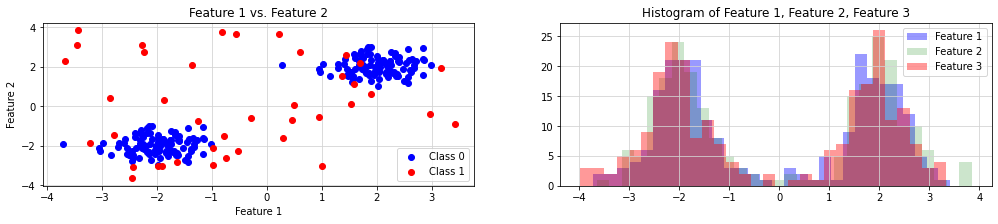

In [46]:
fig,ax = plt.subplots(1, 2, figsize=(17,3)) #create two plots
ax[0].grid(color='lightgray');ax[1].grid(color='lightgray');ax[0].set_axisbelow(True); #set elements of graph
ax[0].scatter(syntheticdf[syntheticdf['Class']==1]['Feature1'],syntheticdf[syntheticdf['Class']==1]['Feature2'], label='Class 0',color='b')
ax[0].scatter(syntheticdf[syntheticdf['Class']==-1]['Feature1'],syntheticdf[syntheticdf['Class']==-1]['Feature2'], label='Class 1', color='r'); ax[0].set(title='Feature 1 vs. Feature 2', xlabel='Feature 1', ylabel='Feature 2')
ax[0].legend()
ax[1].hist(syntheticdf['Feature1'], bins=30, label='Feature 1', alpha=.4, color='b');#.hist(bins=30) #create hitograms
ax[1].hist(syntheticdf['Feature2'], bins=30, label='Feature 2', alpha=.2, color='g');#.hist(bins=30)
ax[1].hist(syntheticdf['Feature3'], bins=30, label='Feature 3', alpha=.4, color='r');#.hist(bins=30)
ax[1].set_title('Histogram of Feature 1, Feature 2, Feature 3')
plt.legend()

Our plots show many outliers scattered through the graph, however, there are several outliers located within the normally distributed data. From our histogram it is apparent there are two normally distributed sets of data in the features, and we can detect the presence of our outliers at zero of the histogram plot. Let's see how iForest detect the presence of outliers.
#### 2. Split the data in to test and train.
Using the datasplit function created at the start, we can split the data at a designated value. Here we are selecting 25% withheld for testing.

In [12]:
#20% of data withheld for testing. Pass x & y with .values to return arrays and not dataframes. Needed format model
x_train, x_test, y_train, y_test= datasplit(syntheticdf, .25, ['Feature1', 'Feature2', 'Feature3'], 'Class');
print('x train shape: ', x_train.shape, '| y train shape: ', y_train.shape);print('x test shape: ', x_test.shape, '| y test shape: ', y_test.shape)

x train shape:  (180, 3) | y train shape:  (180,)
x test shape:  (60, 3) | y test shape:  (60,)


#### 3. Train the model: Understanding Isolation Forest and Its Parameters
Isolation Forest works on the principal that outliers are easily isolated due to their:
1. infrequent occurrence and;
2. spatial relation.

These two factors are important to remember going forward. First let's view a single Isolation Tree with the isotree function created above. Each red line represents a segmentation made by the Isolation Tree function.

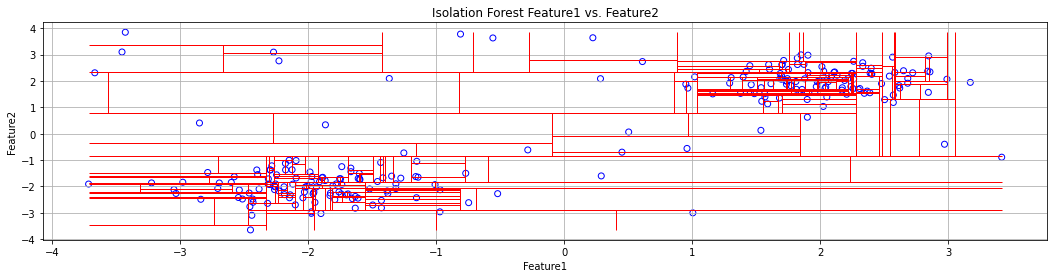

In [13]:
plot_create(syntheticdf, 0, 1, figuresize=(18,4)) #create plot
sub = isotree(syntheticdf[syntheticdf.columns[0:2]], layers=20) #call isotree fxn to view physical splitting of an isotree

We can see how outliers require fewer subdivisions to isolate them from the rest of the data. This is the core principle that drives Isolation Forest. Using the reconstruct function, individual points can be viewed by passing the index of the desired datapoint.

Index 239 : ( 3.42 , -0.89 ): required  5  trees to isolate
Index 180 : ( 1.91 , 2.32 ): required  12  trees to isolate


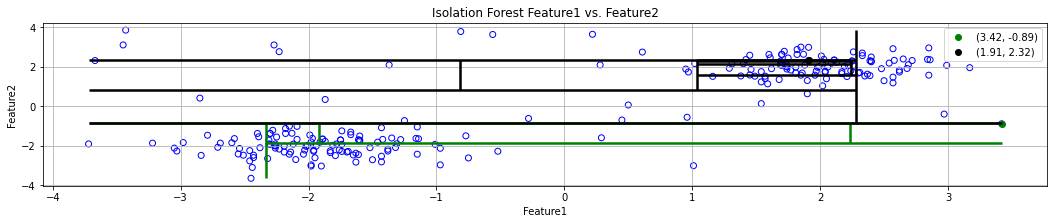

In [14]:
sub=np.around(sub, decimals=2) #round so legend isn't long
reconstruct(sub, 239, 180, linewidth=2.5) #pass index points to reconstruct fxn for plotting

Divinding data into branching trees is known as a Binary Search Tree (BST) within computer science. As additional features are added and the data increases, a single tree is unable to capture the complexity of the dataset. For this reason, the process is iterated over multiple times to create a forest of trees. Keeping this principal in mind as we examine iForest's parameters. 

1. **n_estimators** (*int, default=100*): number of base estimators (or as the number of trees within the forest).
2. **max_samples** (*'auto', int, or float, default='auto'*): number of samples to use for training. iForest does not contain a max_depth parameter like other decision tree models, but instead uses max_samples to determine depth.
3. **contamination** (*'auto' or float, default='auto'*): percentage of data which is suspected to be outliers. This parameter has the greatest effect on the results.
4. **max_features** (*int or float, default=1.0*): number of features to implement into the model. If float, then max_features*X.shape[1]. This means that 1.0 actually includes all features, where 1 is only one feature.

<sub>For more information refer to the [scikit documentation.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)<sub>

With this understanding, we can begin to create the model using the base parameters. We saw earlier in our graph that a few of our outliers appear to be nested within the normal distribution, but when viewing the three dimensional graph many of these outliers are independent of the distributions. This means we should set our max_features to 1.0, which is the default for including all features.

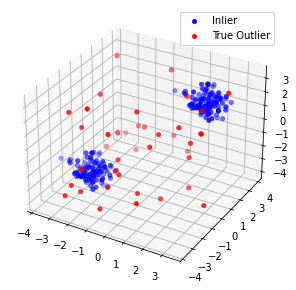

In [15]:
fig = plt.figure(figsize=(20,5))
ax = plt.axes(projection='3d')
ax.scatter(syntheticdf[syntheticdf['Class']==1]['Feature1'], syntheticdf[syntheticdf['Class']==1]['Feature2'], syntheticdf[syntheticdf['Class']==1]['Feature3'], label="Inlier",color='b', linewidth=0.5);
ax.scatter(syntheticdf[syntheticdf['Class']==-1]['Feature1'], syntheticdf[syntheticdf['Class']==-1]['Feature2'], syntheticdf[syntheticdf['Class']==-1]['Feature3'], label="True Outlier",c='r', cmap='viridis', linewidth=0.5);
ax.legend()

Since Isolation Forest is unsupervised, it is uneccessary to input the training values for y into the model like other algorithms using the .fit() function. Let's run the model and see its base estimation.

In [16]:
basemodel=IsolationForest(max_features=1.0, max_samples=180,random_state=42).fit(x_train) #fit the training data to the model
y_pred_train, y_pred_decisionfxn, y_pred_test, y_train_reshape, y_test_score=isomodel(basemodel, x_train, y_train, x_test) #pass to fxn above and receive results.

preddf=pd.DataFrame(data=x_train, columns=['Feature1','Feature2', 'Feature3']) #add results to df
preddf['Class']=y_train_reshape;preddf['ClassPred']=y_pred_train;preddf['Scores']=y_pred_decisionfxn #add results to df

#### 4. Calculate Error

To determine the efficacy of the model we will use standard classification metrics. Below these are shown as the confusion matrix, errors calculated, F1-score, and the accuracy score.

Accuracy Score :  0.94
Classification Report :
              precision    recall  f1-score   support

     Outlier       0.88      0.80      0.84        35
      Inlier       0.95      0.97      0.96       145

    accuracy                           0.94       180
   macro avg       0.91      0.89      0.90       180
weighted avg       0.94      0.94      0.94       180



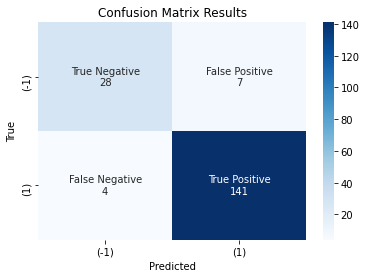

In [17]:
matrix = confusion_matrix(y_train,y_pred_train) #calc confusion matrtix
errors = (y_pred_train!=y_train_reshape).sum() #comparing pred vs true. count if pred is wrong
print("Accuracy Score : ", '{:.2f}'.format(accuracy_score(y_train_reshape,y_pred_train))); print("Classification Report :")
print(classification_report(y_train_reshape,y_pred_train, target_names=['Outlier', 'Inlier']))
group_names = ['True Negative','False Positive','False Negative', 'True Positive'] #make list of cm groups
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()] #make list of counts from cm output
labels = [f'{v1}\n{v2}'for v1, v2 in zip(group_names,group_counts)] #combine into a single list to pass into cm heatmap
labels = np.asarray(labels).reshape(2,2)
ax=plt.subplot()
sns.heatmap(matrix, annot=labels, fmt='', xticklabels=['(-1)', '(1)'],  yticklabels=['(-1)', '(1)'],cmap='Blues');ax.set_title('Confusion Matrix Results'); 
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
#confusion matrix visualization from Dennis T's Medium article [Confusion Matrix Visualization](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

Isolation Forest's output will result in a finalized score of -1 for outlier and 1 for inlier. Looking at our confusion matrix the base model performed well successfully classifying 28 out of 35 outliers. This is a precision of 88%. There was a total of eleven total errors with an accuracy of 94%. Let's see if we can do better.
#### 4. Understanding Results - Contamination and The Anomaly Score
Each datapoint is scored based on the path length *h(x)* to it's terminal node. This score is normalized by the average path length *c(n)* where n is the number of samples. An unsuccessful search in BST is the same as reaching a terminal node in an Isolation Tree. Therefore, the BST function used to calculate an unsuccessful search is used to estimate *c(n)*. The expression is as follows:
$$
\begin{equation}
c(n) = 2H_{(n-1)} - \frac{2(n-1)}{n}
\end{equation}
$$

H is the harmonic number which can be approximated by:
$$
H=E+ln(i)
$$

where E is [Euler's constant](https://en.wikipedia.org/wiki/Euler%27s_constant)\*. With this, the anomaly score is calculated:
$$
\begin{equation}
s(x,m) = 2\frac{-E(h(x))}{c(m)}
\end{equation}
$$

Let's visualize the scores from our model using iForest's decision_function method.  
<sub>*not to be confused with Euler's number\
Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation-based anomaly detection.” ACM Transactions on Knowledge Discovery from Data (TKDD) 6.1 (2012): 3.<sub>

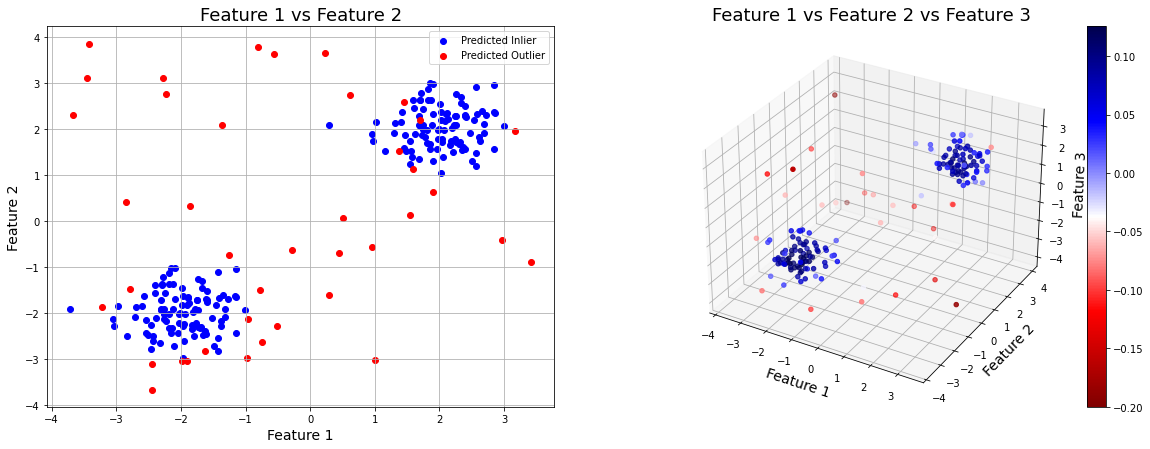

In [18]:
# minscore=int(scoresamp.min()); maxscore=int(scoresamp.max())
fig = plt.figure(figsize = (20,7)); ax1 = fig.add_subplot(121) #set up 2d subplot 
sc1 = ax1.scatter(syntheticdf[syntheticdf['Class']==1]['Feature1'], syntheticdf[syntheticdf['Class']==1]['Feature2'], c = 'b', label='Predicted Inlier') # use this mappable
sc1 = ax1.scatter(syntheticdf[syntheticdf['Class']==-1]['Feature1'], syntheticdf[syntheticdf['Class']==-1]['Feature2'], c = 'r', label='Predicted Outlier') # use this mappable
ax1.set_title("Feature 1 vs Feature 2", fontsize = 18);ax1.set_xlabel("Feature 1", fontsize = 14);ax1.set_ylabel("Feature 2", fontsize = 14)
ax1.legend(); ax1.grid(); ax2 = fig.add_subplot(122, projection='3d') #set up 3d subplot
sc2 = ax2.scatter(preddf['Feature1'], preddf['Feature2'], preddf['Feature3'], c=preddf['Scores'], cmap='seismic_r') #plot, use c to pass scores
ax2.set_title("Feature 1 vs Feature 2 vs Feature 3", fontsize = 18) 
ax2.set_xlabel("Feature 1", fontsize = 14);ax2.set_ylabel("Feature 2", fontsize = 14); ax2.set_zlabel("Feature 3", fontsize = 14)
cbar = fig.colorbar(sc2, ax=ax2) #maps colors to bar
#Plot code used from Andras Deak:https://stackoverflow.com/questions/50938167/two-colorbars-on-two-subplots-same-figure

Here we have applied a color grading to each datapoint's anomaly score. As outlined in the Liu, 2008, a negative score will be classified as an outlier. However, iForest will apply an offset to the anomaly score that is adjusted according to the contamination value. The higher the contamination value, the offset will result in more negative values and therefore more outliers. If contamination is set to 'auto', it will result in a default offset of -0.5 and reflect classifications defined by the original paper. Let's examine this by iterating over the model with different increasing values for contamination.  
<sub>Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on.<sub>

In [19]:
c=np.empty((0,4),float); lowhigh=np.empty((0,len(x_train)), float)#fit model over array of values for contamination
for contam in np.arange(.02,.30,.01):
    contammodel=IsolationForest(max_features=1.0, n_jobs=1000, contamination=contam, random_state=42)
    y_predtrain_contam, y_pred_dfxn, y_pred_test, y_train_contamreshape, y_test_score=isomodel(contammodel, x_train, y_train, x_test)
    c=np.append(c, np.array([[contam, contammodel.offset_, accuracy_score(y_train_contamreshape,y_predtrain_contam), (y_predtrain_contam==-1).sum()/(y_predtrain_contam==1).sum()]]), axis=0)

Plotted Results

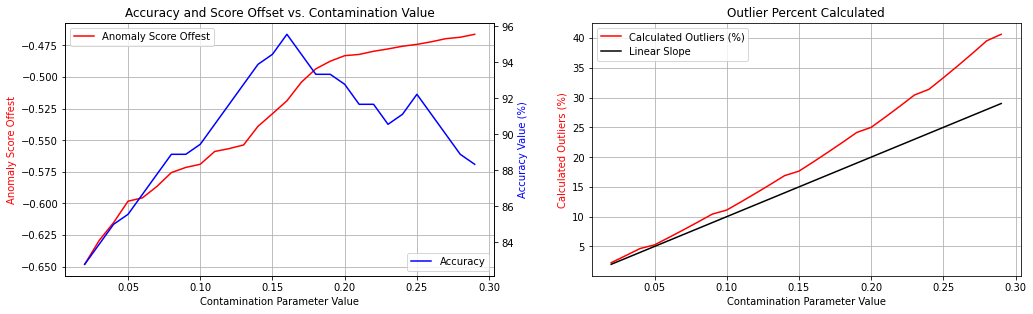

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15,5));subax0 = ax[0].twinx()
ax[0].plot(c[:,0],c[:,1], 'r', label='Anomaly Score Offest')
subax0.plot(c[:,0],c[:,2]*100, 'b', label='Accuracy')
ax[0].set_title('Accuracy and Score Offset vs. Contamination Value');
ax[0].set_xlabel('Contamination Parameter Value')
ax[0].set_ylabel('Anomaly Score Offest', color='r')
subax0.set_ylabel('Accuracy Value (%)', color='b')
ax[0].grid();ax[0].legend(loc='upper left'); subax0.legend(loc='lower right');

ax[1].set_title('Outlier Percent Calculated')
ax[1].plot(c[:,0],c[:,3]*100, 'r', label='Calculated Outliers (%)')
ax[1].plot(c[:,0],c[:,0]*100, 'k', label='Linear Slope')
ax[1].set_xlabel('Contamination Parameter Value')
ax[1].set_ylabel('Calculated Outliers (%)', color='r')
ax[1].grid();ax[1].legend(loc='upper left'); plt.tight_layout(pad=3.0)

The results are somewhat in line with what we expect. As the contamination value increases the offset becomes too great and our accuracy drops. However, one issue was found from this experimentation. Having manually created our outliers, we can determine the actual contamination value of the training data to be 24%. 

The accuracy score is highest at a contamination value of 16%, which is incongruous with our training set. Investigating further, calculating the percent of outliers w.r.t. the predicted training set is higher than the input contamination value. The right graph shows that as the contamination parameter value increases the resulting predictions are higher than the input value. At a contamination parameter of 16%, the predicted outliers is 21% with an accuracy of 95.5%.

In [21]:
print('Contamination of y training data: ', round((len(y_train[y_train==-1])/len(y_train[y_train==1])*100),2),'%')
print('Outlier calculated at contamination parameter value of .16: ', round(c[15][3], 2)*100,'%')
print('Outlier calculated at contamination parameter value of .24: ', round(c[23][3], 2)*100,'%')

Contamination of y training data:  24.14 %
Outlier calculated at contamination parameter value of .16:  21.0 %
Outlier calculated at contamination parameter value of .24:  33.0 %


All parameters were tested over various ranges and combinations, but the cause of the discrepancy could not be located.  Resources online are sparse when attempting to resolve this issue.

<sub>[Stackoverflow: inconsistency between contamination set up and number of outlier prediction in Sklearn isolation Forest](https://stackoverflow.com/questions/66769476/inconsistency-between-contamination-set-up-and-number-of-outlier-prediction-in-s)<sub>
#### 5. Tune Hyperparameters
We can use GridSearchCV to tune our model. Outside of contamination, max_samples is a parameter that can have the greatest results on the model. Unlike some other tree based algorithms, users cannot specify the depth of the tree. Instead, iForest will allow users to decrease the number of samples in the model which in turn defines the depth.
The max depth can be calculated with: 
$$
\begin{equation}
max depth = ceil(log2(n))
\end{equation}
$$
So with 150 samples our max samples are given as 8.

In [22]:
print('Depth of iForest with max samples of 180: ',math.ceil(math.log2(180)))

Depth of iForest with max samples of 180:  8


In [25]:
clf = IsolationForest(random_state=42) #model call
param_grid = {'n_estimators': np.arange(10,220,30), 'max_samples': np.arange(10,170,20)} #parameters set for testing
scoring = make_scorer(f1_score,average='micro') #scorer set
grid_dt_estimator = GridSearchCV(clf, param_grid,scoring=scoring, refit=True,cv=10, return_train_score=True)#call gridsearch
grid_dt_estimator.fit(x_train, y_train)
results=pd.DataFrame(grid_dt_estimator.cv_results_)#grid search to df

GridSearchCV(cv=10, estimator=IsolationForest(random_state=42),
             param_grid={'max_samples': array([ 10,  30,  50,  70,  90, 110, 130, 150]),
                         'n_estimators': array([ 10,  40,  70, 100, 130, 160, 190])},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=micro))

Using the results from GridsearchCV we can see that as we increase max samples our accuracy increases which is to be expects. This parameter must be considered to avoid underfit or overfit.

Additionally, n_estimators, which determines the number of trees shows marginal increase in accuracy when the sample number is adequate. For larger datasets these two parameters should be considered greatly so as to prevent excessive modeling time.

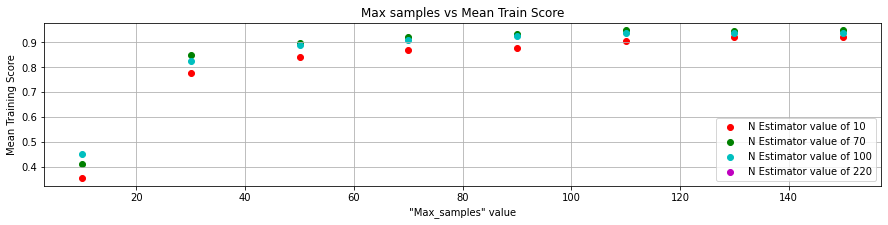

In [45]:
fig, ax = plt.subplots(figsize=(15,3))
plt.title('Max samples vs Mean Train Score'); plt.xlabel('"Max_samples" value'); plt.ylabel('Mean Training Score')
plt.scatter(results[results['param_n_estimators']==10]['param_max_samples'],results[results['param_n_estimators']==10]['mean_train_score'], label='N Estimator value of 10', color='r');
plt.scatter(results[(results['param_n_estimators']==40)]['param_max_samples'],results[(results['param_n_estimators']==40)]['mean_train_score'], label='N Estimator value of 70', color='g');
plt.scatter(results[(results['param_n_estimators']==100)]['param_max_samples'],results[(results['param_n_estimators']==100)]['mean_train_score'], label='N Estimator value of 100', color='c');
plt.scatter(results[(results['param_n_estimators']==220)]['param_max_samples'],results[(results['param_n_estimators']==220)]['mean_train_score'], label='N Estimator value of 220', color='m');
plt.legend(loc='lower right'); plt.grid()

#### 6. Test the model for the withheld data

Input the best parameters into the model and fit for the data withheld for testing.

In [40]:
print('Best Parameters through GridsearchCV: ', grid_dt_estimator.best_params_)

Best Parameters through GridsearchCV:  {'max_samples': 130, 'n_estimators': 40}


In [41]:
bestparam=IsolationForest(max_features=1.0, contamination=.16, max_samples=130, n_estimators=40, bootstrap=False, random_state=42).fit(x_train)
y_pred_train, y_pred_decisionfxn, y_pred_test, y_train_reshape, y_test_score=isomodel(bestparam, x_train, y_train, x_test)
bestparam=pd.DataFrame(data=x_train, columns=['Feature1','Feature2', 'Feature3']) #add results to df
bestparam['Class']=y_train_reshape; bestparam['ClassPred']=y_pred_train#add results to df

View the results.

Errors calculated:  11
Accuracy Score :  0.98
Classification Report :
              precision    recall  f1-score   support

        -1.0       1.00      0.80      0.89         5
         1.0       0.98      1.00      0.99        55

    accuracy                           0.98        60
   macro avg       0.99      0.90      0.94        60
weighted avg       0.98      0.98      0.98        60



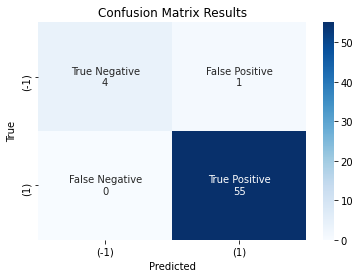

In [42]:
matrix = confusion_matrix(y_test,y_pred_test) #calc confusion matrtix
print("Accuracy Score : ", '{:.2f}'.format(accuracy_score(y_test,y_pred_test))); print("Classification Report :")
print(classification_report(y_test,y_pred_test))
group_names = ['True Negative','False Positive','False Negative', 'True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
# group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}'for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
ax=plt.subplot()
sns.heatmap(matrix, annot=labels, fmt='', xticklabels=['(-1)', '(1)'],  yticklabels=['(-1)', '(1)'],cmap='Blues');ax.set_title('Confusion Matrix Results'); 
ax.set_xlabel('Predicted');ax.set_ylabel('True'); 

With the parameters tested through GridsearchCV the model reported an accuracy of 98% with a single false positive error. There is a potentiality that this model is overfit with such a high score. Although our synthetic dataset is likely not as challenging as a real-world example.  
#### 7. Limitations and Closing Remarks
One limitation worth discussing is BST's implicit bias in the way anomaly scores are produced. When splitting the data over numerous trees in a grid like manner, the resulting scores will return a grid like artifact when weighted. To understand this, it is best to visualize on a two-dimensional plot and so I will rerun the synthetic data using only Feature 1 and 2.

Text(0.5, 1.0, 'Isolation Forest Artifact')

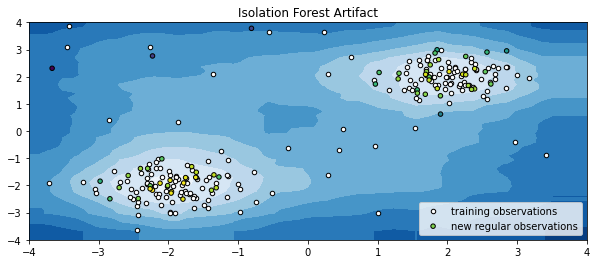

In [43]:
errormodel=IsolationForest(max_features=1.0, random_state=42).fit(syntheticdf[['Feature1', 'Feature2']])
y_pred_train, y_pred_decisionfxn, y_pred_test, y_train_reshape, y_test_score=isomodel(basemodel, x_train, y_train, x_test)
errordf=pd.DataFrame(data=x_train, columns=['Feature1','Feature2', 'Feature3']) #add results to df
errordf['Class']=y_train_reshape; errordf['ClassPred']=y_pred_train#add results to df

xx, yy = np.meshgrid(np.linspace(-4, 4, 50), np.linspace(-4, 4, 50)) #creates a 2d mesh
Z = errormodel.decision_function(np.c_[xx.ravel(), yy.ravel()]) #applies the anomaly score to the entire mesh
Z = Z.reshape(xx.shape) #reshapes array for modeling
plt.subplots(figsize=(10,4))
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r) #plots the mesh over the graph
b1 = plt.scatter(x_train[:,0], x_train[:,1], c="white", s=20, edgecolor="k")
c = plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test_score, s=20, edgecolor="k")
plt.legend([b1, c], ["training observations", "new regular observations"], loc="lower right",)
plt.title("Isolation Forest Artifact")
#code from scikit learn Isolation Forest example: https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

The colored contour map overlayed is the anomaly score applied to a mesh. Within the two normal distributions, the color reflects a high score resulting in an inlier classification. However, lighter color can be seen branching out laterally due to the artifact caused by the grid like nature of BST. An outlier falling in these regions might result in a false positive if the contamination parameter was sufficiently low.